In [9]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm
import arviz as az

from scipy import stats
from scipy.special import expit


from causalgraphicalmodels import CausalGraphicalModel
import daft

import warnings

print('Running on pymc3 version {}'.format(pm.__version__))

warnings.filterwarnings('ignore')
%config Inline.figure_format = 'retina'
az.style.use("arviz-darkgrid")

Running on pymc3 version 3.11.2


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

pd.options.display.max_columns = None
pd.options.display.max_rows = 200

In [3]:
def standardize(array, reference=None):
    if reference is None:
        reference = array
    return (array - reference.mean()) / reference.std()

## Ex. 1

In [4]:
df = pd.read_csv('data/reedfrogs.csv', sep=',')
print(df.shape)
df.head()

(48, 5)


,density,pred,size,surv,propsurv
0,10,no,big,9,0.9
1,10,no,big,10,1.0
2,10,no,big,7,0.7
3,10,no,big,10,1.0
4,10,no,small,9,0.9


In [5]:
tank = np.arange(df.shape[0])
n_tanks = df.shape[0]

In [6]:
# simple model

with pm.Model() as m_6_0:

    a = pm.Normal('a', 0, 1.5, shape=n_tanks)
    p = pm.math.invlogit(a[tank])

    S = pm.Binomial("S", n=df.density, p=p, observed=df.surv)
    trace_6_0 = pm.sample()

# az.summary(trace_6_0, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


Model definition 

\begin{split}\begin{aligned}
A_i  &\sim Binomial(N_i, p_i) \\
logit(p_i) &= \alpha[G_i] \\
\alpha_i &\sim Normal(\bar{\alpha}, sigma) \\
\bar{\alpha} &\sim Normal(0, 1.5) \\
\sigma &\sim Exponential(1) \\


\end{aligned}\end{split}




In [10]:
# multi-level model
with pm.Model() as m_6_1:
    a_bar = pm.Normal("a_bar", 0.0, 1.5)
    sigma = pm.Exponential("sigma", 1.0)

    a = pm.Normal('a', a_bar, sigma, shape=n_tanks)
    p = pm.math.invlogit(a[tank])

    S = pm.Binomial("S", n=df.density, p=p, observed=df.surv)
    trace_6_1 = pm.sample()

# az.summary(trace_6_1, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma, a_bar]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


In [11]:
az.compare({"m6_0": trace_6_0, "m6_1": trace_6_1},'waic')


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m6_1,0,-99.943595,20.784308,0.000000,1.0,3.613470,0.0000,True,log
m6_0,1,-107.521018,25.822084,7.577423,0.0,2.346485,1.8113,True,log


## A) Simulate priors for different sigma values directly from the model

In [56]:
prior_pred_dict = dict()
exp_values = [0.1, 1, 10]
models = ['one', 'two', 'three']
tank = df.index

for x, m in zip(exp_values, models):
    with pm.Model() as m:
        a_bar = pm.Normal("a_bar", 0.0, 1.5)
        sigma = pm.Exponential("sigma", x)

        a = pm.Normal('a', a_bar, sigma, shape=n_tanks)
        p = pm.Deterministic('p', pm.math.invlogit(a[tank]))

        S = pm.Binomial("S", n=df.density, p=p, observed=df.surv)
        prior = pm.sample_prior_predictive(var_names='a')

        prior_pred_dict[x] = prior['a']


Text(0.5, 1.0, 'probability distribution for different sigma values')

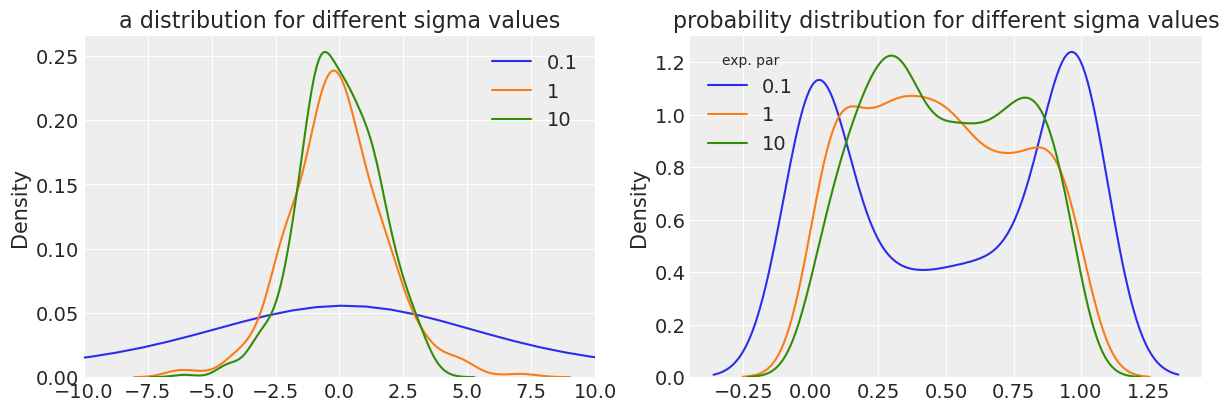

In [61]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 4))

for x in exp_values:
    sns.kdeplot(prior_pred_dict[x][:,0], ax=ax1)
ax1.legend(exp_values) 
ax1.set(title='a distribution for different sigma values', xlim=(-10, 10))

for x in exp_values:
    sns.kdeplot(expit(prior_pred_dict[x][:,0]), ax=ax2)
ax2.legend(exp_values, title='exp. par')

ax2.set_title('probability distribution for different sigma values')

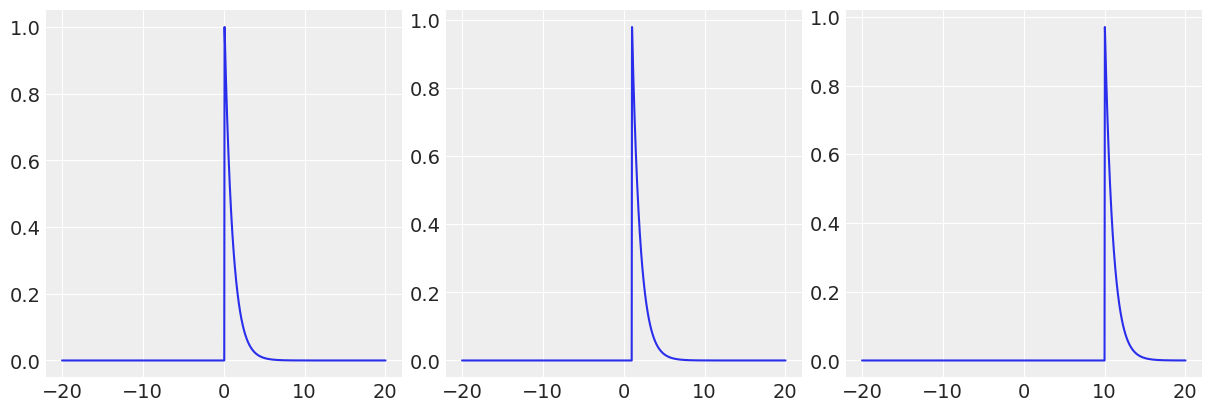

In [82]:
#check shape of exponential priors on sigma

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

exp_values = [0.1, 1, 10]
axes = [ax1, ax2, ax3]
x = np.linspace(-20, 20, 1000)
for ax, exp in zip(axes, exp_values):
    y = stats.expon.pdf(x, exp)
    ax.plot(x, y)



## B) Simulate priors manually

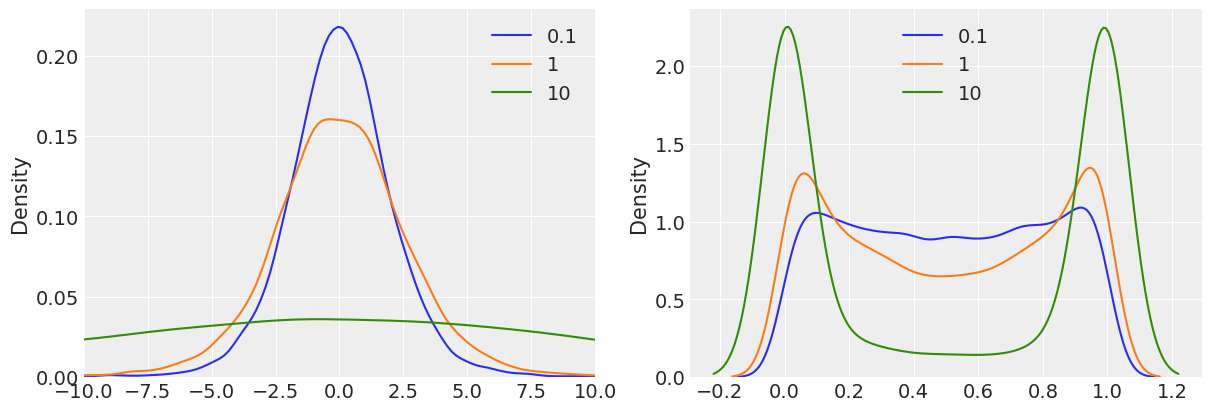

In [77]:
exp_values = [0.1, 1, 10]
n = 10000

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
for x in exp_values:
    a_bar = stats.norm.rvs(0, 1.5, size=n)
    sigma = stats.expon.rvs(x, size=n)

    a = stats.norm.rvs(a_bar, sigma, size=n)
    sns.kdeplot(a, ax=ax1, label=f'{x}')

    sns.kdeplot(expit(a), ax=ax2, label=f'{x}')

ax1.set_xlim(-10, 10)
ax1.legend()

ax2.legend()


# Ex. 2

Model definition 

\begin{split}\begin{aligned}
A_i  &\sim Binomial(N_i, p_i) \\
logit(p_i) &= \alpha[P_i, S_i] \\
\alpha_i &\sim Normal(\bar{\alpha}, sigma) \\
\bar{\alpha} &\sim Normal(0, 1.5) \\
\sigma &\sim Exponential(1) \\


\end{aligned}\end{split}


In [53]:
print(df.shape)
df.head()

(48, 5)


,density,pred,size,surv,propsurv
0,10,no,big,9,0.9
1,10,no,big,10,1.0
2,10,no,big,7,0.7
3,10,no,big,10,1.0
4,10,no,small,9,0.9


In [63]:
df = df.rename(columns={'size':'size_'})

In [79]:
pred_id = pd.factorize(df.pred)[0]
pred_idx = pd.factorize(df.pred)[1]

size_id = pd.factorize(df.size_)[0]
size_idx = pd.factorize(df.size_)[1]

df.dens_s = standardize(df.density)


In [78]:
df.density.unique()

array([10, 25, 35])

In [75]:
print(len(pred_idx), len(size_idx))

2 2


In [76]:
with pm.Model() as m_6_2:
    a_bar = pm.Normal("a_bar", 0.0, 1.5)
    sigma = pm.Exponential("sigma", 1.0)

    a = pm.Normal('a', a_bar, sigma, shape=(len(pred_idx), len(size_idx)))
    
    p = pm.math.invlogit(a[pred_id, size_id])

    S = pm.Binomial("S", n=df.density, p=p, observed=df.surv)
    trace_6_2 = pm.sample()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma, a_bar]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


In [77]:
pm.summary(trace_6_2,round_to=2)

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,0.94,0.73,-0.41,2.33,0.01,0.01,3680.59,2174.66,1.0
"a[0, 0]",2.60,0.23,2.17,3.04,0.00,0.00,3958.85,3091.67,1.0
"a[0, 1]",2.45,0.22,2.04,2.87,0.00,0.00,3537.69,2644.03,1.0
"a[1, 0]",-0.56,0.12,-0.80,-0.34,0.00,0.00,4287.37,2851.19,1.0
"a[1, 1]",0.34,0.12,0.12,0.57,0.00,0.00,3917.84,3136.14,1.0
sigma,1.63,0.61,0.77,2.78,0.01,0.01,3343.90,2341.23,1.0


# Ex. 3

Now estimate the causal effect of density on survival. Consider whether pred modifies the effect of density. There are several good ways to include density in your binomial GLM.

In [82]:
with pm.Model() as m_6_3:
    a_bar = pm.Normal("a_bar", 0.0, 1.5)
    sigma = pm.Exponential("sigma", 1.0)

    a = pm.Normal('a', a_bar, sigma, shape=(len(pred_idx)))
    b = pm.Normal('b', 0, 1)

    p = pm.math.invlogit(a[pred_id] + b*df.dens_s)

    S = pm.Binomial("S", n=df.density, p=p, observed=df.surv)
    trace_6_3 = pm.sample()



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, sigma, a_bar]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


In [83]:
pm.summary(trace_6_3,round_to=2)

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,0.80,0.94,-1.11,2.49,0.02,0.01,2835.98,2071.71,1.0
a[0],2.65,0.17,2.33,2.95,0.00,0.00,3054.42,2873.50,1.0
a[1],-0.01,0.09,-0.18,0.17,0.00,0.00,2405.51,2763.98,1.0
b,-0.24,0.09,-0.43,-0.07,0.00,0.00,2273.42,2308.02,1.0
sigma,1.73,0.78,0.62,3.13,0.02,0.01,2320.72,2465.84,1.0
